In [39]:
import sys

# New Section

In [40]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/MyDrive/code/146']
sys.path += ['/content/drive/MyDrive/code/146/nutil']

### ========== TODO : END ========== ###


In [42]:
from nutil import *

In [43]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [44]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [45]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        
        n = y.shape[0]
        gt50 = np.count_nonzero(y)
        self.probabilities_ = np.zeros(2)
        self.probabilities_[0] = (n - gt50) / n
        self.probabilities_[1] = gt50 / n

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        y = np.random.choice([0,1],size=X.shape[0],p=self.probabilities_)
        
        ### ========== TODO : END ========== ###

        return y


In [46]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [47]:
sss = StratifiedShuffleSplit(n_splits=5,test_size = 0.5, random_state = 0)
x = sss.split([0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10])
print(x)

<generator object BaseShuffleSplit.split at 0x7f5cea41b9e0>


In [56]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    train_error = 0.0
    test_error = 0.0
    f1_s = 0.0
    
    for i in np.arange(ntrials):
      
      sss = StratifiedShuffleSplit(n_splits=5,test_size = test_size, random_state = 0)
      t_err = 0.0
      ts_err = 0.0
      f1 = 0.0
      
      for j, (train_index, test_index) in enumerate(sss.split(X, y)):
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[train_index])
        t_err += 1 - metrics.accuracy_score(y[train_index], y_pred, normalize=True)
        y_pred = clf.predict(X[test_index])
        ts_err += 1 - metrics.accuracy_score(y[test_index], y_pred, normalize=True)
        f1 += metrics.f1_score(y[test_index], y_pred, average='micro')
      
      train_error += t_err / 5
      test_error += ts_err / 5
      f1_s += f1 / 5

    train_error /= ntrials
    test_error /= ntrials
    f1_score = f1_s / ntrials

    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [49]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error k=3.000: 0.114
	-- training error k=5.000: 0.129
	-- training error k=7.000: 0.152
Investigating various classifiers...
(0.2399999999999996, 0.2399999999999996, 0.7600000000000002)
(0.36775000000000024, 0.3760000000000001, 0.6240000000000009)
(0.0, 0.1831599999999999, 0.8168399999999997)
(0.13874999999999996, 0.19000000000000006, 0.8100000000000012)
Finding the best k...
0.22599999999999998
0.20599999999999996
0.21599999999999997
0.23199999999999998
0.20799999999999996
0.18600000000000003
0.18600000000000003
0.20200000000000004
0.19400000000000003
0.19400000000000003
0.19600000000000004
0.17200000000000001
0.17
0.17
0.17800000000000002
0.17200000000000001
0.17
0.17
0.17200000000000001
0.17400000000000002
0.18000000000000002
0.18400000000000002
0.18000000

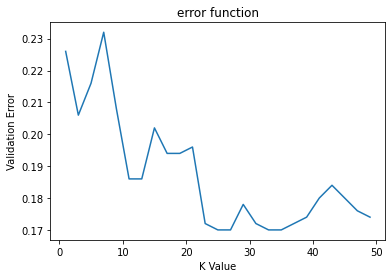

13


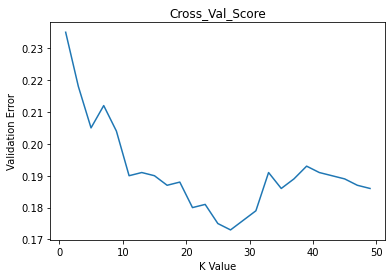

Investigating depths...
[0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76] [0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76 0.76]
[0.82222222 0.81555556 0.81888889 0.79444444 0.79444444 0.79222222
 0.79555556 0.82111111 0.79555556 0.79666667] [0.73 0.79 0.76 0.8  0.8  0.82 0.79 0.76 0.79 0.78]
[0.85       0.83333333 0.82888889 0.82777778 0.82777778 0.82111111
 0.82333333 0.83555556 0.82222222 0.82666667] [0.73 0.78 0.8  0.84 0.85 0.85 0.85 0.77 0.86 0.82]
[0.85555556 0.84222222 0.83666667 0.83666667 0.83777778 0.83111111
 0.84555556 0.84555556 0.83       0.83333333] [0.75 0.78 0.79 0.84 0.85 0.88 0.84 0.78 0.86 0.83]
[0.86555556 0.85555556 0.85333333 0.84       0.84777778 0.84666667
 0.85222222 0.85222222 0.84555556 0.85555556] [0.75 0.81 0.82 0.84 0.84 0.89 0.85 0.77 0.89 0.82]
[0.87777778 0.87222222 0.87222222 0.85111111 0.86111111 0.86
 0.86666667 0.86111111 0.86333333 0.86666667] [0.78 0.8  0.79 0.85 0.84 0.88 0.86 0.76 0.87 0.83]
[0.89222222 0.88555556 0.88555556 0.87       0.871111

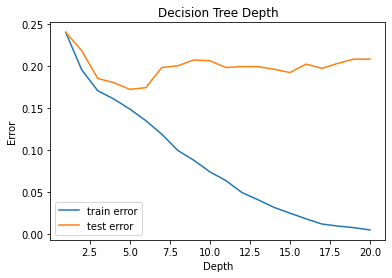

0
2
0
3


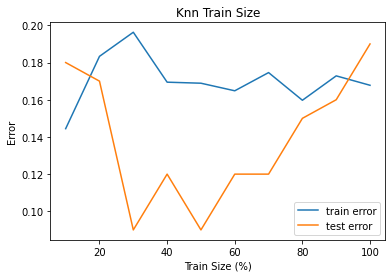

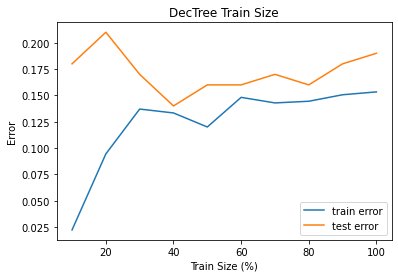

Done


In [57]:
from re import T

######################################################################
# main
######################################################################

def main():
    
    
    
    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/MyDrive/code/146/adult_subsample.csv"
    ### ========== TODO : END ========== ###
    

    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features

    


    #========================================
    # part a: plot histograms of each feature
    # print('Plotting...')
    # plot_histograms (X, y, Xnames=Xnames, yname=yname)
    # plt.show()
  


    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)
    #     Pre-process the data by standardizing it. See the sklearn.preprocessing.StandardScaler package
    # for details. After performing the standardization such as normalization please run all
    # previous steps part (b) to part (h) and report what difference you see in performance.
    # Solution:
    
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf2 = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
    clf2.fit(X, y)                  # fit training data using the classifier
    y_pred = clf2.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf3 = DecisionTreeClassifier(criterion='entropy')
    clf3.fit(X, y)       
    y_pred = clf3.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    for i in [3,5,7]:
      clf4 = KNeighborsClassifier(n_neighbors=i)
      clf4.fit(X, y)
      y_pred = clf4.predict(X)
      train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
      # print the error for each k
      print('\t-- training error k=%.3f' % i + ': %.3f' % train_error)

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    clf = MajorityVoteClassifier()
    summary = error(clf, X, y, ntrials=100)
    print(summary)

    clf = RandomClassifier()
    summary = error(clf, X, y, ntrials=100)
    print(summary)

    clf = DecisionTreeClassifier(criterion='entropy')
    summary = error(clf, X, y, ntrials=100)
    print(summary)

    clf = KNeighborsClassifier(n_neighbors=5)
    summary = error(clf, X, y, ntrials=100)
    print(summary)

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
#     using 10-fold cross validation. You may find the
# cross_val_score(...) from scikit-learn helpful. Run 10-fold cross validation for all odd
# numbers ranging from 1 to 50 as the number of neighbors. Then plot the validation error
# against the number of neighbors, k.
    
    arr = np.zeros(25,)
    arr2 = np.zeros(25,)
    for k in np.arange(1,50,2):
      clf = KNeighborsClassifier(n_neighbors=k)
      arr2[int((k-1)/2)] = np.sum(cross_val_score(clf,X,y,cv=10,scoring='accuracy'))/10
      print(error(clf,X,y,ntrials=3,test_size=0.1)[1])
      arr[int((k-1)/2)] = error(clf,X,y,ntrials=10,test_size=0.1)[1]

    print(np.argmin(arr))
    plt.plot(np.arange(1,50,2),arr)
    plt.ylabel('Validation Error')
    plt.xlabel('K Value')
    plt.title('error function')
    plt.show()

    print(np.argmin(1-arr2))
    plt.plot(np.arange(1,50,2),1-arr2)
    plt.ylabel('Validation Error')
    plt.xlabel('K Value')
    plt.title('Cross_Val_Score')
    plt.show()

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    #    increasing depth limits, specifically, 1, 2, . . . , 20. You may find
    # cross_validate(...) from scikit-learn helpful. Then plot the average training error and
    # test error against the depth limit. Include this plot in your writeup, making sure to label all
    # axes and include a legend for your classifiers. What is the best depth limit to use for this
    # data? Do you see overfitting? Justify your answers using the plot.

    t_err = np.zeros(20)
    ts_err = np.zeros(20)
    for i in np.arange(1,21,1):
      clf = DecisionTreeClassifier(criterion='entropy',max_depth=i)
      tmp = cross_validate(clf,X,y,return_train_score = True,cv=10)
      print(tmp['train_score'],tmp['test_score'])
      t_err[i-1] = 1 - np.sum(tmp['train_score'])/10
      ts_err[i-1] = 1 - np.sum(tmp['test_score'])/10

    print(np.argmin(t_err))
    print(np.argmin(ts_err))

    line1, = plt.plot(np.arange(1,21,1),t_err, label='train error')
    line2, = plt.plot(np.arange(1,21,1),ts_err, label='test error')
    plt.legend(handles=[line1, line2])
    plt.ylabel('Error')
    plt.xlabel('Depth')
    plt.title('Decision Tree Depth')
    plt.show()
    

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)
    #     Another useful tool for evaluating classifiers is learning curves, which show how classifier
    # performance (e.g. error) relates to experience (e.g. amount of training data). For this experiment,
    # first generate a random 90/10 split of the training data using train_test_split from
    # scikit-learn with random_state set to 0. Then, do the following experiments considering
    # the 90% fraction as training and 10% for testing.
    # Run experiments for the decision tree and k-nearest neighbors classifier with the best depth
    # limit and k value you found above. This time, vary the amount of training data by starting
    # with splits of 0.10 (10% of the data from 90% fraction) and working up to full size 1.00
    # (100% of the data from 90% fraction) in increments of 0.10. Then plot the decision tree and
    # k-nearest neighbors training and test error against the amount of training data. Include this
    # plot in your writeup, and provide a 1-2 sentence description of your observations.

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    knn_t_err = np.zeros(10)
    knn_ts_err = np.zeros(10)
    dt_t_err = np.zeros(10)
    dt_ts_err = np.zeros(10)
    n = int(X_train.shape[0]/10)
    for i in np.arange(0,10,1):
      x_tr = X_train[0:n,:]
      y_tr = y_train[0:n,]
      #Decision Tree
      clf = DecisionTreeClassifier(criterion='entropy',max_depth=5) 
        # train
      clf.fit(x_tr, y_tr)
        # test error 
      y_pred = clf.predict(X_test)        
      dt_ts_err[i] = 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
        # train error
      y_pred = clf.predict(x_tr)        
      dt_t_err[i] = 1 - metrics.accuracy_score(y_tr, y_pred, normalize=True)
      #KNearNeighb
      clf = KNeighborsClassifier(n_neighbors=15) 
        # train
      clf.fit(x_tr, y_tr)
        # test error 
      y_pred = clf.predict(X_test)
      knn_ts_err[i] = 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
        # train error
      y_pred = clf.predict(x_tr)        
      knn_t_err[i] = 1 - metrics.accuracy_score(y_tr, y_pred, normalize=True)

      n += int(X_train.shape[0]/10)

    print(np.argmin(knn_t_err))
    print(np.argmin(knn_ts_err))
    print(np.argmin(dt_t_err))
    print(np.argmin(dt_ts_err))
    line1, = plt.plot(np.arange(10,110,10),knn_t_err, label='train error')
    line2, = plt.plot(np.arange(10,110,10),knn_ts_err, label='test error')
    plt.legend(handles=[line1, line2])
    plt.ylabel('Error')
    plt.xlabel('Train Size (%)')
    plt.title('Knn Train Size')
    plt.show()

    line1, = plt.plot(np.arange(10,110,10),dt_t_err, label='train error')
    line2, = plt.plot(np.arange(10,110,10),dt_ts_err, label='test error')
    plt.legend(handles=[line1, line2])
    plt.ylabel('Error')
    plt.xlabel('Train Size (%)')
    plt.title('DecTree Train Size')
    plt.show()



    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
